<a href="https://colab.research.google.com/github/RudreshVeerkhare/Data_Science_Lab/blob/main/Horse_Colic_Dataset_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name - Rudresh Veerkhare  
UID - 2018130061  
Batch - B  

Download Dataset

In [65]:
!gdown --id "1kVhFA2e5mcEdMpqioyIz7JXOBmUlZvpq" -O "horse.csv"

Downloading...
From: https://drive.google.com/uc?id=1kVhFA2e5mcEdMpqioyIz7JXOBmUlZvpq
To: /content/horse.csv
100% 53.7k/53.7k [00:00<00:00, 54.6MB/s]


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "white", rc = {
    'figure.figsize': (11.7, 8.27)
})

df_org = pd.read_csv("horse.csv")

In [67]:
print(df_org.shape)
df_org.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


Our dataset has 399 rows and 28 features  
Lets check what is the proportion of missing values

In [68]:
missing_stats = df_org.isna().sum().sort_values(ascending = False) * 100 / len(df_org)
missing_stats

nasogastric_reflux_ph    82.274247
abdomo_protein           66.220736
abdomo_appearance        55.183946
abdomen                  39.464883
nasogastric_reflux       35.451505
nasogastric_tube         34.782609
rectal_exam_feces        34.113712
peripheral_pulse         23.076923
rectal_temp              20.066890
respiratory_rate         19.397993
temp_of_extremities      18.729097
abdominal_distention     18.729097
pain                     18.394649
mucous_membrane          15.719064
peristalsis              14.715719
total_protein            11.036789
capillary_refill_time    10.702341
packed_cell_volume        9.698997
pulse                     8.026756
lesion_2                  0.000000
surgical_lesion           0.000000
lesion_3                  0.000000
lesion_1                  0.000000
surgery                   0.000000
outcome                   0.000000
age                       0.000000
hospital_number           0.000000
cp_data                   0.000000
dtype: float64

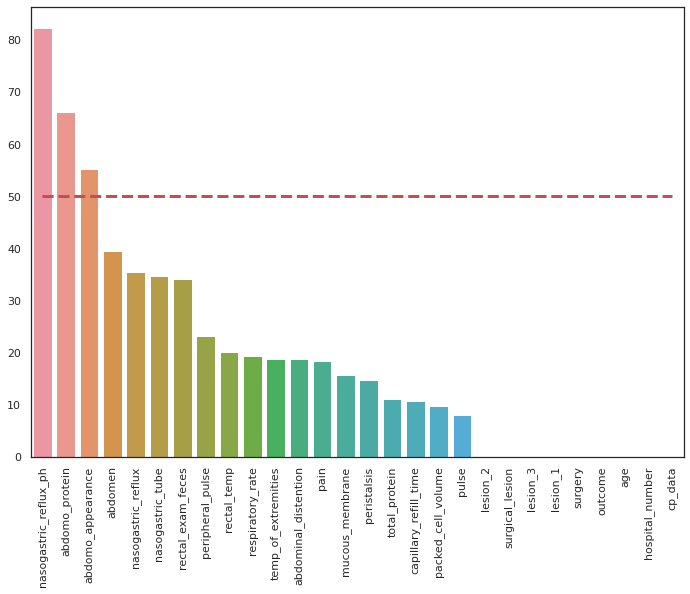

In [69]:
plt.plot([0, 27], [50,50], 'r--', lw=3)
g = sns.barplot(x = missing_stats.index, y = missing_stats.values)
_ = g.set_xticklabels(missing_stats.index, rotation = 90)

There are 3 columns having more than 50% missing values, we'll drop them directly

In [70]:
df_wip = df_org.drop(missing_stats[missing_stats > 50].index, axis = 1)
print(df_wip.shape)
df_wip.head()

(299, 25)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,decreased,distend_large,45.0,8.4,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,absent,other,50.0,85.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,normal,normal,33.0,6.7,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,decreased,NaN,48.0,7.2,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,died,no,4300,0,0,no


In [71]:
df_wip.drop("hospital_number", axis = 1, inplace = True)

Hospitan no is unique id, so not much important information

There are 3 lesions and each one has multiple of type, to simplify we'll create a new feature counting total no. of lesions 

In [72]:
df_wip['lesion_count'] = np.minimum(1, df_wip['lesion_1']) + np.minimum(1, df_wip['lesion_2']) + np.minimum(1, df_wip['lesion_3'])
df_wip.drop(["lesion_1", "lesion_2", "lesion_3"], axis = 1, inplace = True)
df_wip.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,outcome,surgical_lesion,cp_data,lesion_count
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,decreased,distend_large,45.0,8.4,died,no,no,1
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,absent,other,50.0,85.0,euthanized,no,no,1
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,normal,normal,33.0,6.7,lived,no,yes,0
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,decreased,NaN,48.0,7.2,died,yes,yes,1
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,died,no,no,1


There are still significant amount of missing values present in the data,  
we will impute that data using mode for categorical and mean for numerical feat

Impute Numerical features with mean values

In [73]:
for colname in df_wip.columns[df_wip.dtypes != 'object']:
    _mean = df_wip[colname].mean()
    print(colname, "\t\t", _mean)
    df_wip[colname] = df_wip[colname].fillna(_mean)

rectal_temp 		 38.16861924686195
pulse 		 72.0
respiratory_rate 		 30.46058091286307
packed_cell_volume 		 46.30740740740741
total_protein 		 24.27443609022557
lesion_count 		 0.8394648829431438


Impute Categorical Values

In [74]:
for colname in df_wip.columns[df_wip.dtypes == 'object']:
    _mode = df_wip[colname].mode()[0]
    print(colname, "\t\t", _mode)
    df_wip[colname] = df_wip[colname].fillna(_mode)

surgery 		 yes
age 		 adult
temp_of_extremities 		 cool
peripheral_pulse 		 normal
mucous_membrane 		 normal_pink
capillary_refill_time 		 less_3_sec
pain 		 mild_pain
peristalsis 		 hypomotile
abdominal_distention 		 none
nasogastric_tube 		 slight
nasogastric_reflux 		 none
rectal_exam_feces 		 absent
abdomen 		 distend_large
outcome 		 lived
surgical_lesion 		 yes
cp_data 		 no


In [75]:
df_wip.isna().any().any()

False

No missing values are remaning now.

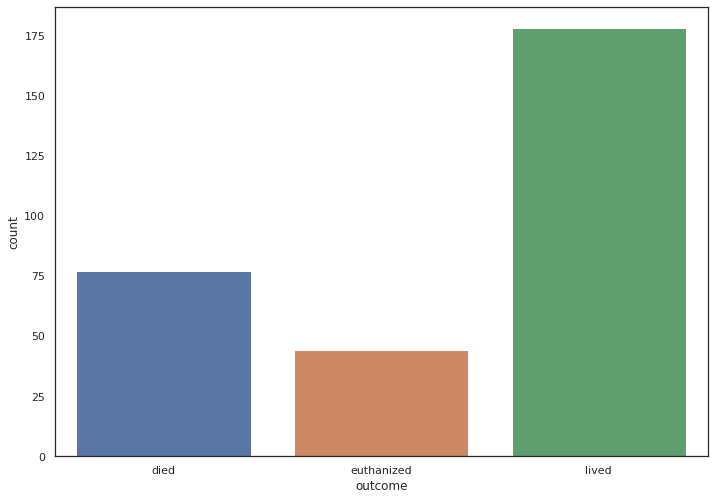

In [76]:
sns.countplot(x = "outcome", data = df_wip)

Dataset has more lived datapoints

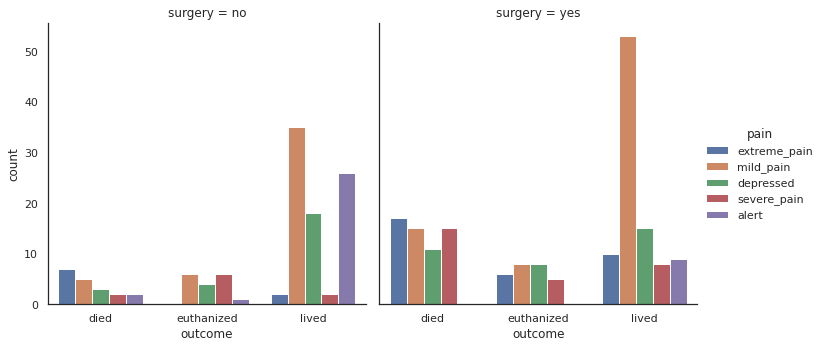

In [77]:
g = sns.catplot(data=df_wip, x='outcome', hue='pain', col='surgery', kind='count')

From above, died horses tend to have extreme_pain while lived horses with surgery have mild_pain

LabelEncode categorical Features by manual ordinal encoder was done looking at the documentation to ensure they follow the correct scale

In [78]:
def label_encoder(df):
    df['surgery'] = df['surgery'].map({'yes':1,'no':2}).astype('float64')
    df['age'] = df['age'].map({'adult':1,'young':2}).astype('float64')
    df['temp_of_extremities'] = df['temp_of_extremities'].map({'normal':1,'warm':2,'cool':3,'cold':4}).astype('float64')
    df['peripheral_pulse'] = df['peripheral_pulse'].map({'increased':2,'normal':1,'reduced':3,'absent':4}).astype('float64')
    df['mucous_membrane'] = df['mucous_membrane'].map({'dark_cyanotic':6,'bright_red':5,'pale_cyanotic':4,'pale_pink':3,'bright_pink':2,'normal_pink':1}).astype('float64')
    df['capillary_refill_time'] = df['capillary_refill_time'].map({'more_3_sec':3, '3':2, 'less_3_sec':1}).astype('float64')
    df['pain'] = df['pain'].map({'extreme_pain':5, 'severe_pain':4, 'mild_pain':3, 'depressed':2, 'alert':1}).astype('float64')
    df['peristalsis'] = df['peristalsis'].map({'absent':4, 'hypomotile':3, 'normal':2, 'hypermotile':1}).astype('float64')
    df['abdominal_distention'] = df['abdominal_distention'].map({'severe':4,'moderate':3,'slight':2,'none':1}).astype('float64')
    df['nasogastric_tube'] = df['nasogastric_tube'].map({'significant':3, 'slight':2, 'none':1}).astype('float64')
    df['nasogastric_reflux'] = df['nasogastric_reflux'].map({'more_1_liter':3, 'less_1_liter':2, 'none':0}).astype('float64')
    df['rectal_exam_feces'] = df['rectal_exam_feces'].map({'absent':4, 'decreased':3, 'increased':2, 'normal':1}).astype('float64')
    df['abdomen'] = df['abdomen'].map({'distend_large':5, 'distend_small':4, 'firm':3, 'other':2, 'normal':1}).astype('float64')
    # df['abdomo_appearance'] = df['abdomo_appearance'].map({'serosanguious':3, 'cloudy':2, 'clear':1}).astype('float64')
    df['outcome'] = df['outcome'].map({'euthanized':3, 'died':2, 'lived':1}).astype('float64')
    df['surgical_lesion'] = df['surgical_lesion'].map({'yes':1,'no':0}).astype('float64')
    return df

In [79]:
df_encoded = label_encoder(df_wip)

In [80]:
df_encoded

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,outcome,surgical_lesion,cp_data,lesion_count
0,2.0,1.0,38.500000,66.0,28.0,3.0,3.0,1.0,3.0,5.0,4.0,4.0,2.0,0.0,3.0,5.0,45.0,8.400000,2.0,0.0,no,1
1,1.0,1.0,39.200000,88.0,20.0,3.0,1.0,4.0,1.0,3.0,4.0,2.0,2.0,0.0,4.0,2.0,50.0,85.000000,3.0,0.0,no,1
2,2.0,1.0,38.300000,40.0,24.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,33.0,6.700000,1.0,0.0,yes,0
3,1.0,2.0,39.100000,164.0,84.0,4.0,1.0,6.0,3.0,2.0,4.0,4.0,1.0,2.0,3.0,5.0,48.0,7.200000,2.0,1.0,yes,1
4,2.0,1.0,37.300000,104.0,35.0,3.0,1.0,6.0,3.0,3.0,3.0,1.0,2.0,0.0,4.0,5.0,74.0,7.400000,2.0,0.0,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,1.0,38.168619,120.0,70.0,4.0,1.0,4.0,3.0,2.0,4.0,1.0,2.0,0.0,4.0,5.0,55.0,65.000000,3.0,0.0,no,1
295,2.0,1.0,37.200000,72.0,24.0,3.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0,0.0,4.0,4.0,44.0,24.274436,3.0,1.0,yes,1
296,1.0,1.0,37.500000,72.0,30.0,4.0,3.0,4.0,1.0,4.0,4.0,3.0,2.0,0.0,3.0,5.0,60.0,6.800000,2.0,1.0,no,1
297,1.0,1.0,36.500000,100.0,24.0,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,50.0,6.000000,1.0,1.0,yes,1


In [81]:
df_encoded.dtypes

surgery                  float64
age                      float64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities      float64
peripheral_pulse         float64
mucous_membrane          float64
capillary_refill_time    float64
pain                     float64
peristalsis              float64
abdominal_distention     float64
nasogastric_tube         float64
nasogastric_reflux       float64
rectal_exam_feces        float64
abdomen                  float64
packed_cell_volume       float64
total_protein            float64
outcome                  float64
surgical_lesion          float64
cp_data                   object
lesion_count               int64
dtype: object

In [84]:
df_encoded.drop("cp_data", axis = 1, inplace = True)

**Correlation Analysis**

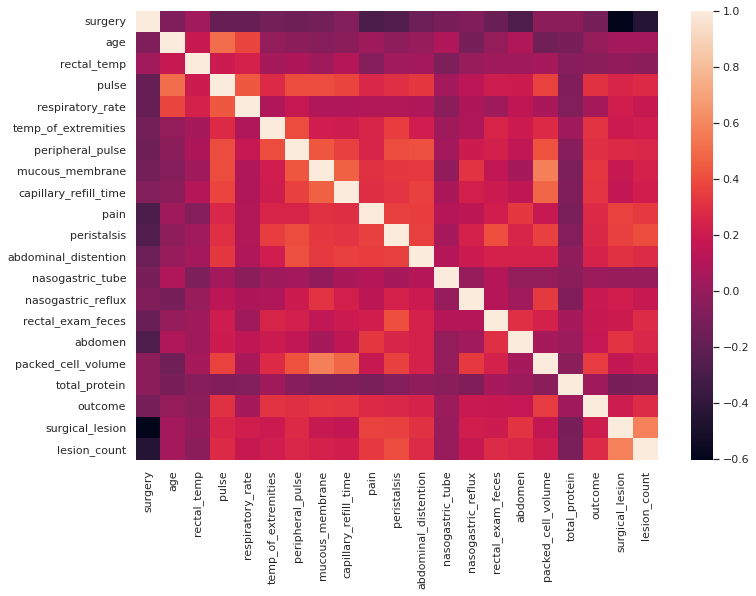

In [85]:
corr = df_encoded.corr()
sns.heatmap(corr)

In [88]:
corr["outcome"].sort_values(ascending = False)

outcome                  1.000000
packed_cell_volume       0.345058
mucous_membrane          0.326351
capillary_refill_time    0.319908
temp_of_extremities      0.315627
pulse                    0.305420
peripheral_pulse         0.303244
lesion_count             0.282910
pain                     0.277921
peristalsis              0.269845
abdominal_distention     0.246464
surgical_lesion          0.209143
nasogastric_reflux       0.190175
rectal_exam_feces        0.182677
abdomen                  0.169277
respiratory_rate         0.056886
total_protein            0.025773
nasogastric_tube         0.021049
age                     -0.004083
rectal_temp             -0.050697
surgery                 -0.117619
Name: outcome, dtype: float64

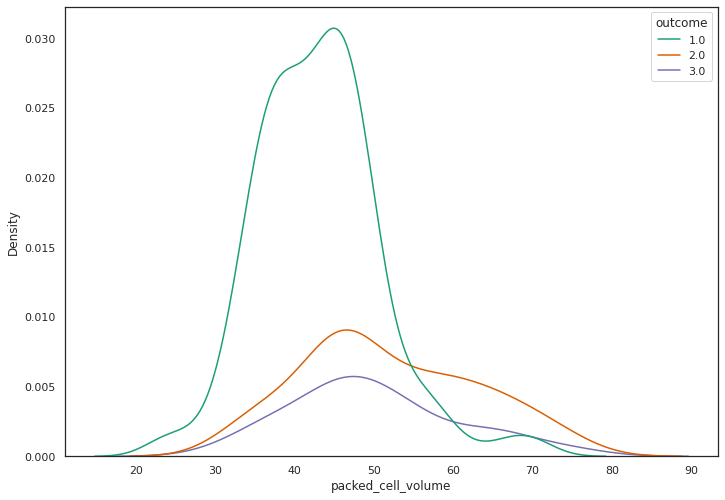

In [98]:
sns.kdeplot(x = 'packed_cell_volume', data = df_encoded, hue = "outcome", palette="Dark2")

**packed_cell_volume** 30 - 50 high chance of lived, more than 60 then died

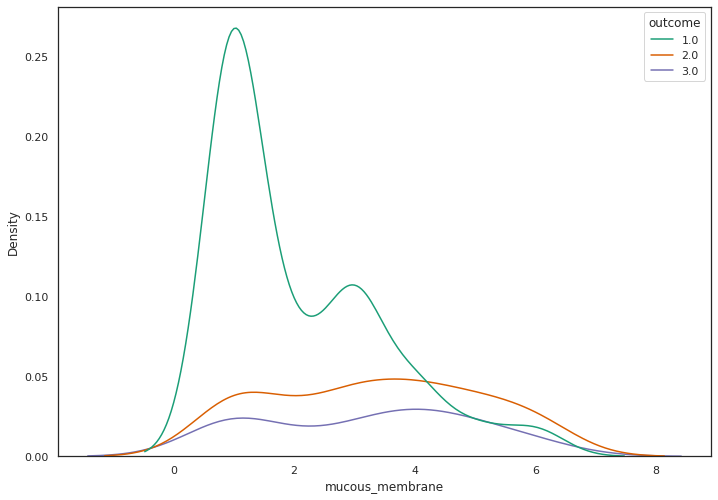

In [99]:
sns.kdeplot(x = 'mucous_membrane', data = df_encoded, hue = "outcome", palette="Dark2")

high values of **mucous_membrane** are associated with higher chances of death

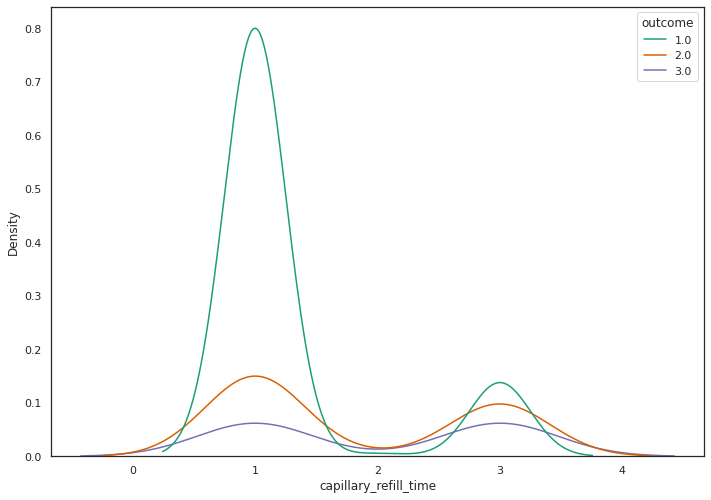

In [100]:
sns.kdeplot(x = 'capillary_refill_time', data = df_encoded, hue = "outcome", palette="Dark2")

having less than 3 has more chances of survival

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop("outcome", axis = 1), 
    df_encoded["outcome"], 
    test_size=0.1, 
    random_state=42
)

In [102]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [105]:
from sklearn.metrics import classification_report

print(classification_report(log_reg.predict(X_test), y_test))

              precision    recall  f1-score   support

         1.0       0.81      0.62      0.70        21
         2.0       0.50      0.67      0.57         6
         3.0       0.33      0.67      0.44         3

    accuracy                           0.63        30
   macro avg       0.55      0.65      0.57        30
weighted avg       0.70      0.63      0.65        30



Finally we got accuracy score of **63%** 